In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator

In [2]:
data=pd.read_csv('Data/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.describe().T

,count,unique,top,freq
review,50000,49582,Loved today's show!!! It was a variety and not...,5
sentiment,50000,2,negative,25000


In [4]:
data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [5]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def removing_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def clean_text(text):
    text = strip_html(text)
    text = removing_square_brackets(text)
    return text

In [6]:
data['review']=data['review'].apply(clean_text)

In [7]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
def removing_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [9]:
data['review']=data['review'].apply(removing_special_characters)

In [10]:
lb=LabelBinarizer()
data['sentiment']=lb.fit_transform(data['sentiment'])

In [11]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1


In [12]:
X_train, y_train, X_test, y_test = data.review[:40000], data.sentiment[:40000], data.review[40000:], data.sentiment[40000:]

In [13]:
tf_vec = TfidfVectorizer(min_df=20,max_df=0.5,ngram_range=(1,2))

In [14]:
cv_X_train = tf_vec.fit_transform(X_train)
cv_X_test = tf_vec.transform(X_test)

In [15]:
cv_X_train.shape,cv_X_test.shape

((40000, 60356), (10000, 60356))

**Model Fitting**

In [16]:
lr = LogisticRegression()

In [17]:
model = lr.fit(cv_X_train,y_train)

In [18]:
model.score(cv_X_train,y_train)

0.9455

In [19]:
model.score(cv_X_test,y_test)

0.9032

In [20]:
pd.DataFrame(confusion_matrix(y_test,model.predict(cv_X_test)))

,0,1
0,4480,513
1,455,4552


In [21]:
accuracy_score(y_test,model.predict(cv_X_test))

0.9032

In [22]:
print(classification_report(y_test,model.predict(cv_X_test)))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      4993
           1       0.90      0.91      0.90      5007

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [23]:
feature_to_coef = {
    word: coef for word, coef in zip(
        tf_vec.get_feature_names(), model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

('great', 8.44782735457837)
('excellent', 6.372000331861714)
('perfect', 5.101750691633429)
('wonderful', 5.088939540262751)
('the best', 4.4978816310873615)


In [24]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('bad', -9.241920786176367)
('worst', -8.438329562001037)
('awful', -7.044491289349207)
('the worst', -6.724906036092104)
('boring', -6.346468327835344)


In [25]:
pos_words=''
for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:100]:
    pos_words=pos_words+ str(best_positive)

In [26]:
neg_words=''
for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1])[:100]:
    neg_words=neg_words+ str(best_negative)

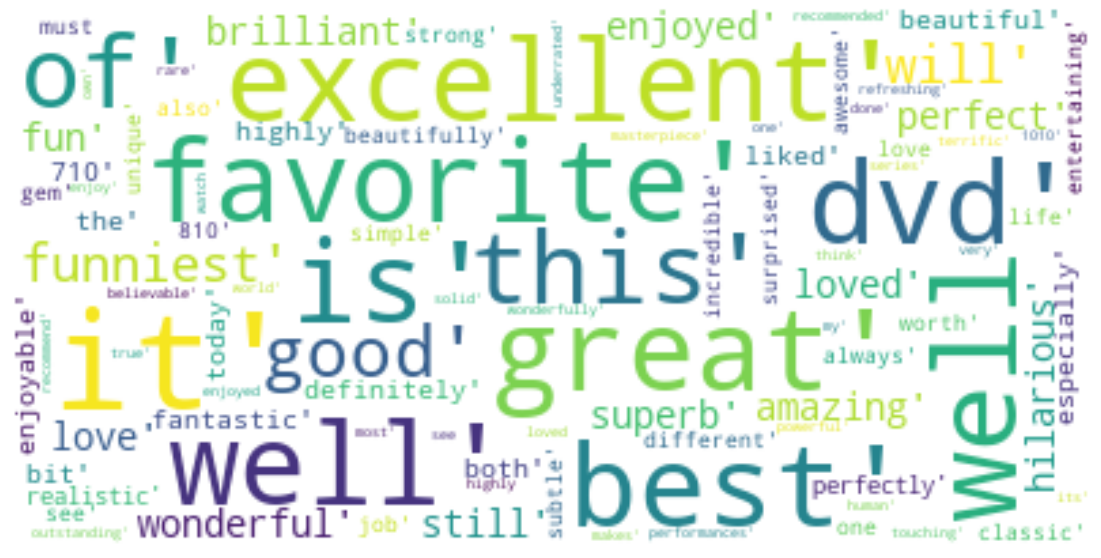

In [27]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(pos_words)

# Displaying the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

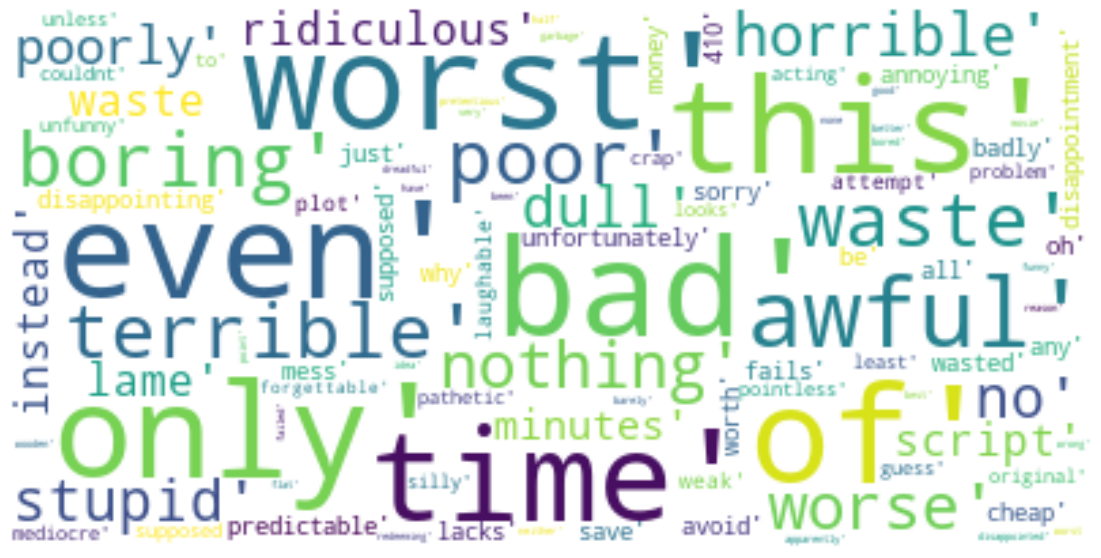

In [28]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neg_words)

# Displaying the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()